In [1]:
import pickle as pkl

In [2]:
filename = "sim_results/market-marl-nash-3-04-21-2022-02-03-20150_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)


In [3]:
l = list(dir(res))

In [4]:
import numpy as np
import seaborn as sns

In [5]:
import pandas as pd

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)

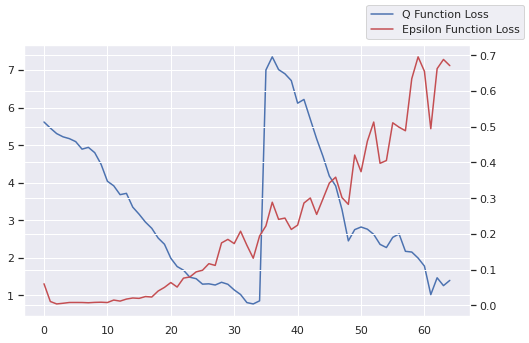

In [6]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()
data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="r")
ax.figure.legend()


In [7]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)


In [8]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

<AxesSubplot:>

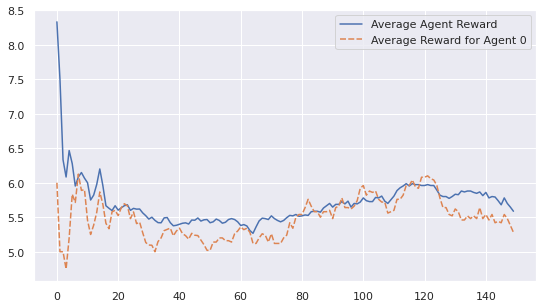

In [9]:
sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [10]:
res.state_tracker


[3.3333333333333335]

In [11]:
state_key = [0.0, 0.0, 0.0, 8.0]

res.sna_policy_dict_iter[repr(state_key)][0]

In [12]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.29256391912373747
0.04729018146970276
0.23390691008516115
0.13406257622945048
0.9454341711222074
0.9231062038247865
0.5498794413040651
0.6336318376618623
0.902526343526543
0.5706366424799063
4


In [13]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.08690369635134479
0.4881284209955355
0.09624667156345076
0.33369447176782846
0.8233315589098196
0.5556520321431938
0.13187221280279798
0.7951976062801666
0.07205333332401664
0.15643796439927526
4


In [14]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.9448579358289002
0.032040132611964714
0.4809564755195185
0.7337314147870997
0.9051270509154368
0.0061314603073509555
0.536328006583276
0.7885945494485362
0.7175736846282129
0.22592140791788273
0


In [16]:
res.state_tracker

[3.3333333333333335]